## Import Libraries Packages, Downloads

In [1]:
#manipulation and plotting libraries
import numpy as np
import pandas as pd
import warnings
import random
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import math as mt

warnings.filterwarnings('ignore')

/Users/omarafifi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/omarafifi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
#ML libraries
#warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

## Loading and Processing Data
`Note: (Because none of the processing we are doing involves imputation or such, we are doing the processing before the split)`

In [3]:
#warnings.filterwarnings('ignore')


Data = pd.read_csv('formatted_data.csv')

## Plotting

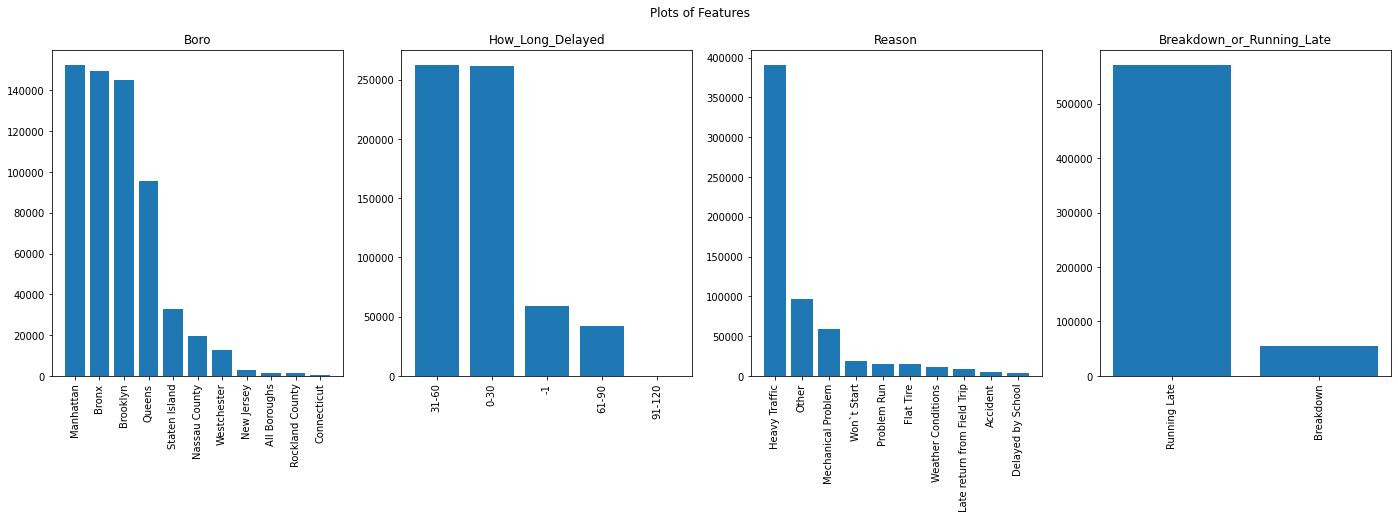

In [4]:
#warnings.filterwarnings('ignore')

columns_to_plot_Data = ['Boro','How_Long_Delayed' ,'Reason', 'Breakdown_or_Running_Late']

fig, axs = plt.subplots(1,4, figsize=(24, 6))
fig.suptitle("Plots of Features")
fig.subplots_adjust(hspace = .5, wspace=.2)
axs = axs.ravel()

i = 0
for column_name in columns_to_plot_Data:

    counts = Data[column_name].value_counts()
    
    # Rotate the tick labels in the second subplot
    axs[i].bar(counts.index, counts.values)
    axs[i].set_title(f"{column_name}")
    axs[i].set_xticklabels(counts.index, rotation=90)
    i += 1



In [5]:
def process(df): 

    #copy dataframe
    data = df.copy()
    #data.columns = data.columns.astype(str)

    #making a dictionary since we need to do a lot of conversion
    to_binary = {'Yes':1, 'No':0}

    #dropping columns we won't be able to use
    data = data.drop(['Busbreakdown_ID', 'Created_On', 
            'Informed_On','Incident_Number', 
            'Last_Updated_On', 'School_Age_or_PreK', 
            'School_Year', 'Route_Number', 'Schools_Serviced',
            'Run_Type', 'Bus_No', 'Bus_Company_Name'], axis = 1)
    
    data = data.dropna()

    #mapping literals to binary values
    data['Breakdown_or_Running_Late'] = data['Breakdown_or_Running_Late'].map({'Breakdown':1, 'Running Late':0})
    data['Has_Contractor_Notified_Parents'] = data['Has_Contractor_Notified_Parents'].map(to_binary)
    data['Has_Contractor_Notified_Schools'] = data['Has_Contractor_Notified_Schools'].map(to_binary)
    data['Have_You_Alerted_OPT'] = data['Have_You_Alerted_OPT'].map(to_binary)

    #getting month/date values
    data['Occurred_On'] = pd.to_datetime(data['Occurred_On'])
    data['Year'] = data['Occurred_On'].dt.year
    data['Month'] = data['Occurred_On'].dt.month
    data['Day'] = data['Occurred_On'].dt.day
    data['Hour'] = data['Occurred_On'].dt.hour
    data['Mins'] = data['Occurred_On'].dt.minute
    data['Weekday'] = data['Occurred_On'].dt.weekday


    data["sin_month"] = np.sin(2*np.pi*data["Month"]/max(data["Month"]))
    data["cos_month"] = np.cos(2*np.pi*data["Month"]/max(data["Month"]))
    data["sin_hour"] = np.sin(2*np.pi*data["Hour"]/max(data["Hour"]))
    data["cos_hour"] = np.cos(2*np.pi*data["Hour"]/max(data["Hour"]))
    data["sin_mins"] = np.sin(2*np.pi*data["Mins"]/max(data["Mins"]))
    data["cos_mins"] = np.cos(2*np.pi*data["Mins"]/max(data["Mins"]))

    #one hot encode boro
    #data['Boro'] = data['Boro'].fillna('None')
    for boro in data['Boro'].unique():
        data[boro] = (data['Boro'] == boro).astype(int)

    # one hot encode breakdown reason
    for reason in data['Reason'].unique():
        data[reason] = (data['Reason'] == reason).astype(int)

    data = data.drop(['Boro'], axis = 1)
    data = data.drop(['Reason'], axis = 1)

    #plot some features

    i = 0
    columns_to_plot_df = ['Month', 'Day', 'Hour', 'Weekday']

    fig, axs = plt.subplots(1,4, figsize=(24, 6))
    fig.suptitle("Plots of Features")
    fig.subplots_adjust(hspace = .5, wspace=.2)
    axs = axs.ravel()

    for column_name in columns_to_plot_df:
        
        counts = data[column_name].value_counts().sort_index()
        
        # Rotate the tick labels in the second subplot
        axs[i].bar(counts.index, counts.values)
        axs[i].set_title(f"{column_name}")
        i += 1

    data = data.drop(['Occurred_On', 'Month', 'Day', 'Hour', 'Mins'], axis = 1)

    return data


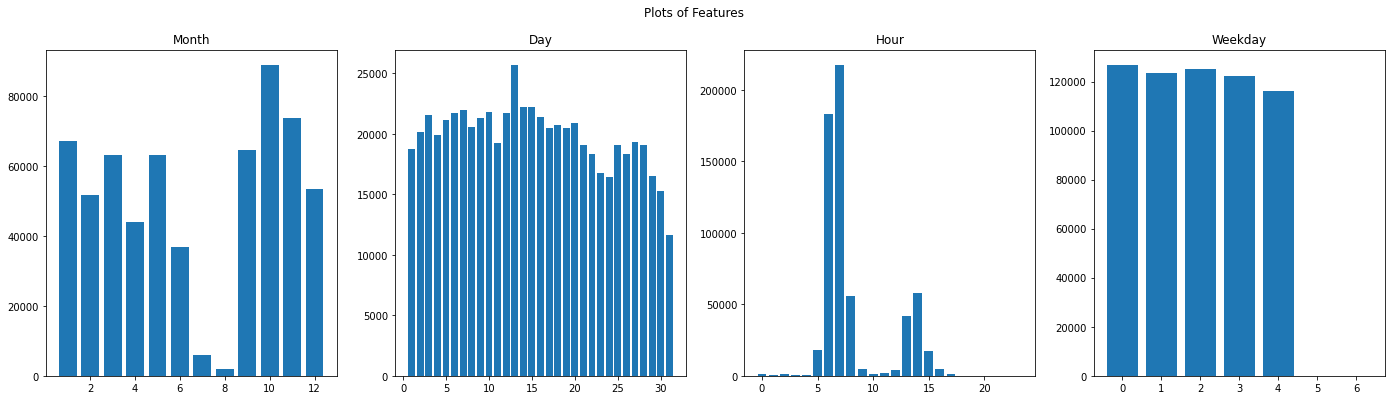

In [6]:
#Process the data
df = process(Data)


### Train Test Split

In [50]:
from itertools import combinations

pairs = list(combinations(np.unique(df['How_Long_Delayed']),2))

classes = {0:'0-30', 1: '31-60', 2:'61-90', 3:'91-120', 4:'-1'}
inverse_classes = {'0-30':0, '31-60':1, '61-90':2, '91-120':3, '-1':4}

#this method takes all the pairwise choices of the labels and returns the classes
def pairwise_sets(df, pair_list):
    #getting the pairwise rows of the data frame

    pairings = {}
    sum = 0

    for pair in pair_list:

        all_rows_with_labels = df.loc[(df['How_Long_Delayed'].isin(pair))]

        y = all_rows_with_labels['How_Long_Delayed']
        X = all_rows_with_labels.drop(['How_Long_Delayed'], axis = 1)

        pairings[pair] = [X,y] 
    return(pairings)




In [87]:
# split data into training and testing data at a .9 ratio
training_data = df.sample(frac = .9)
testing_data = df.drop(training_data.index)

training_paired = pairwise_sets(training_data, pairs) 
testing_paired= pairwise_sets(testing_data, pairs)


## Building a Baseline Classifier
#### 1) (Almost) Random Guessing


In [88]:
models = {}

for pair in pairs:

    (X_train, y_train) = training_paired[pair]


    to_binary = {pair[0]:0, pair[1]:1}
    y_train = y_train.map(to_binary)
    
    
    pipe = Pipeline(
        [
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree = 1)),
            ('pca', PCA(n_components=3)),
            ('mod', LogisticRegression())

        ])

    grid_cv = GridSearchCV(pipe, 
                        param_grid=
        {
            'mod': [ LogisticRegression()],
            'scaler': [StandardScaler()],
            'poly__degree': [1],

        },
        verbose = 3,
        cv = 2,
        return_train_score= True
    )
    
    grid_cv.fit(X_train, y_train)

    best_estimator = grid_cv.best_estimator_

    models[pair] = best_estimator






Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END mod=LogisticRegression(), poly__degree=1, scaler=StandardScaler();, score=(train=0.973, test=0.973) total time=   0.8s
[CV 2/2] END mod=LogisticRegression(), poly__degree=1, scaler=StandardScaler();, score=(train=0.973, test=0.974) total time=   0.6s
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END mod=LogisticRegression(), poly__degree=1, scaler=StandardScaler();, score=(train=0.960, test=0.960) total time=   0.6s
[CV 2/2] END mod=LogisticRegression(), poly__degree=1, scaler=StandardScaler();, score=(train=0.960, test=0.960) total time=   0.6s
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END mod=LogisticRegression(), poly__degree=1, scaler=StandardScaler();, score=(train=0.929, test=0.929) total time=   0.2s
[CV 2/2] END mod=LogisticRegression(), poly__degree=1, scaler=StandardScaler();, score=(train=0.925, test=0.925) total time=   0.2s
Fitting 2 folds for each of 1 c

### Evaluation

('-1', '0-30')
('-1', '31-60')
('-1', '61-90')
('-1', '91-120')
('0-30', '31-60')
('0-30', '61-90')
('0-30', '91-120')
('31-60', '61-90')
('31-60', '91-120')
('61-90', '91-120')


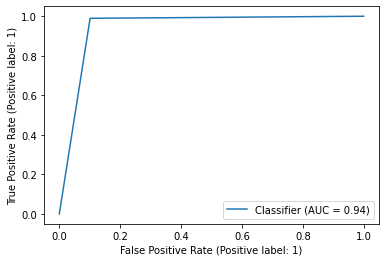

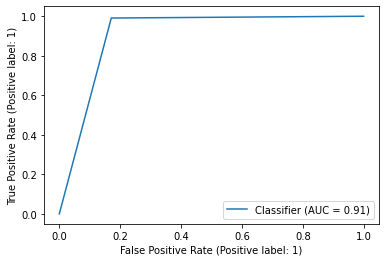

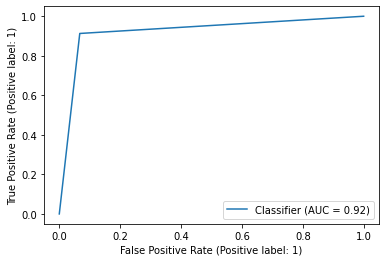

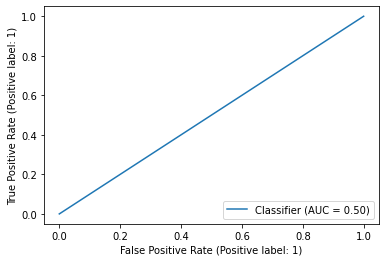

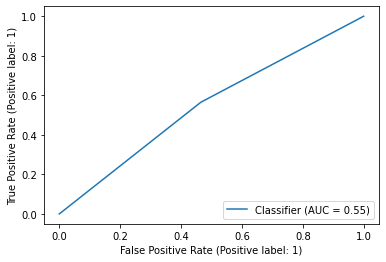

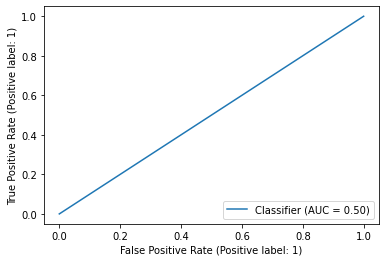

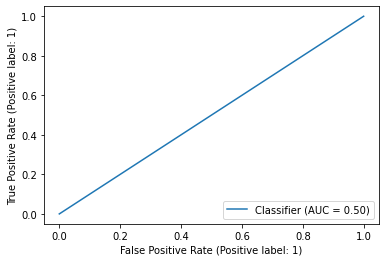

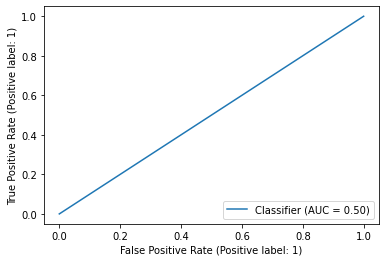

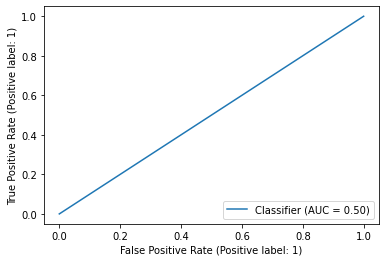

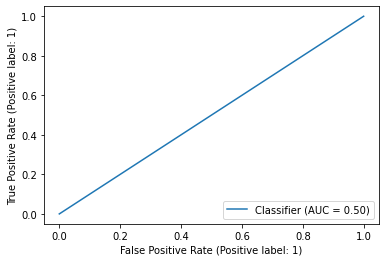

In [91]:
from sklearn.metrics import RocCurveDisplay

for pair in pairs:
    
    classifier = models[pair]

    (X_test, y_test) = testing_paired[pair]
    y_pred = classifier.predict(X_test)

    to_binary = {pair[0]:0, pair[1]:1}
    y_test = y_test.map(to_binary)

    print(pair)
    RocCurveDisplay.from_predictions(y_test, y_pred)
    
